# Toy Data

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import torch
import torch.nn
import matplotlib.pyplot as plt

seed = 1337
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

### Describing Normal Distribution

array([ 2.29681269,  2.50971764,  2.67818567,  1.24492128,  3.20666447,
        0.98873543,  2.44274929,  3.33721701,  4.54883597,  1.62926344,
        4.4252914 ,  2.72053609,  2.44037209,  4.18638337,  4.69851891,
        1.30877984,  2.30047716,  3.58296284,  3.97822263,  1.78262789,
        1.67060455,  2.99854526,  1.68534732,  2.62038826,  4.26521065,
        3.12066774,  3.14794178,  0.24627421,  2.64310368,  3.00771784,
        4.47827716,  2.04238537,  4.32900811,  2.01415037,  3.4715572 ,
        2.99125347,  3.36701869,  4.11855474,  2.99161006,  3.46631538,
        4.2632687 ,  2.09834535,  1.97115731,  3.56967842,  3.64166478,
        3.25981193,  4.19317814,  1.95369964,  3.13988892,  1.26934416,
        2.86937688,  1.68973998,  0.82868758,  1.93381859,  2.96683816,
        4.46639575,  3.8766431 ,  3.66998958,  3.69744951,  2.74721457,
        3.56798711,  3.30438786,  1.9999704 ,  0.54358217,  3.25230702,
        3.76312042,  1.41654535,  3.19804228,  3.08525223,  3.64

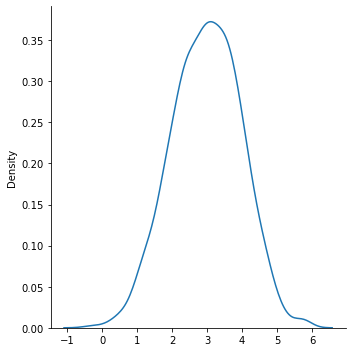

In [2]:
x = np.random.normal(3, size=1000)
sns.displot(x, kind="kde")
x

array([[ 0.11528351,  2.39337554],
       [-2.17418039,  3.95345259],
       [-1.65117864,  3.20528393],
       ...,
       [-2.38086264,  3.88241551],
       [-2.83094104,  2.52611051],
       [-2.59688377,  1.85840306]])

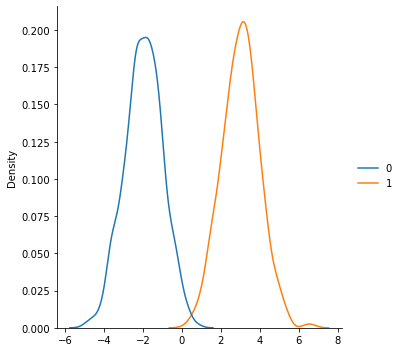

In [3]:
x = np.random.normal(loc=(-2, 3), size=(1000, 2))
sns.displot(x, kind="kde")
x

In [4]:
x = np.linspace(0, 5, 6)
y = np.linspace(0, 9, 10)

xx, yy = np.meshgrid(x, y)
print(xx)
print()
print(yy)

[[0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]
 [0. 1. 2. 3. 4. 5.]]

[[0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5. 5.]
 [6. 6. 6. 6. 6. 6.]
 [7. 7. 7. 7. 7. 7.]
 [8. 8. 8. 8. 8. 8.]
 [9. 9. 9. 9. 9. 9.]]


In [5]:
xy = np.vstack([xx.ravel(), yy.ravel()]).T
xy

array([[0., 0.],
       [1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.],
       [5., 0.],
       [0., 1.],
       [1., 1.],
       [2., 1.],
       [3., 1.],
       [4., 1.],
       [5., 1.],
       [0., 2.],
       [1., 2.],
       [2., 2.],
       [3., 2.],
       [4., 2.],
       [5., 2.],
       [0., 3.],
       [1., 3.],
       [2., 3.],
       [3., 3.],
       [4., 3.],
       [5., 3.],
       [0., 4.],
       [1., 4.],
       [2., 4.],
       [3., 4.],
       [4., 4.],
       [5., 4.],
       [0., 5.],
       [1., 5.],
       [2., 5.],
       [3., 5.],
       [4., 5.],
       [5., 5.],
       [0., 6.],
       [1., 6.],
       [2., 6.],
       [3., 6.],
       [4., 6.],
       [5., 6.],
       [0., 7.],
       [1., 7.],
       [2., 7.],
       [3., 7.],
       [4., 7.],
       [5., 7.],
       [0., 8.],
       [1., 8.],
       [2., 8.],
       [3., 8.],
       [4., 8.],
       [5., 8.],
       [0., 9.],
       [1., 9.],
       [2., 9.],
       [3., 9.],
       [4., 9.

In [6]:
z = np.sum(np.sin(xy), axis=1)
z

array([ 0.        ,  0.84147098,  0.90929743,  0.14112001, -0.7568025 ,
       -0.95892427,  0.84147098,  1.68294197,  1.75076841,  0.98259099,
        0.08466849, -0.11745329,  0.90929743,  1.75076841,  1.81859485,
        1.05041743,  0.15249493, -0.04962685,  0.14112001,  0.98259099,
        1.05041743,  0.28224002, -0.61568249, -0.81780427, -0.7568025 ,
        0.08466849,  0.15249493, -0.61568249, -1.51360499, -1.71572677,
       -0.95892427, -0.11745329, -0.04962685, -0.81780427, -1.71572677,
       -1.91784855, -0.2794155 ,  0.56205549,  0.62988193, -0.13829549,
       -1.03621799, -1.23833977,  0.6569866 ,  1.49845758,  1.56628403,
        0.79810661, -0.0998159 , -0.30193768,  0.98935825,  1.83082923,
        1.89865567,  1.13047825,  0.23255575,  0.03043397,  0.41211849,
        1.25358947,  1.32141591,  0.55323849, -0.34468401, -0.54680579])

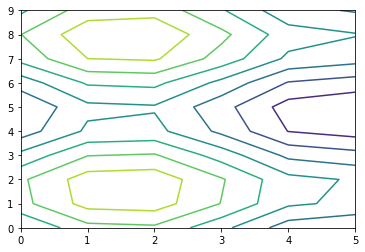

In [7]:
plt.contour(xx, yy, z.reshape(xx.shape))

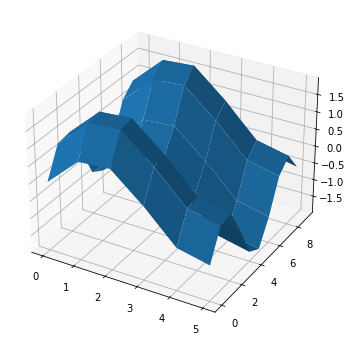

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xx, yy, z.reshape(xx.shape))

In [9]:
TOP_CENTER = (3, 3)
BOTTOM_CENTER = (3, -2)

def get_toy_data(batch_size, top_center=TOP_CENTER, bottom_center=BOTTOM_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:  # (1)
            x_data.append(np.random.normal(loc=top_center))
            y_targets[batch_i] = 1
        else:
            x_data.append(np.random.normal(loc=bottom_center))
    return (torch.tensor(x_data, dtype=torch.float),
            torch.tensor(y_targets, dtype=torch.float))

x_data, y_truth = get_toy_data(10)
x_data, y_truth

(tensor([[ 4.2900, -2.3396],
         [ 3.2726, -1.2065],
         [ 2.9597,  3.8050],
         [ 0.6997,  0.9042],
         [ 3.5776,  3.4091],
         [ 3.8604, -0.0618],
         [ 5.3586,  3.8221],
         [ 0.6602, -2.7646],
         [ 4.6037, -3.4670],
         [ 3.1307, -0.9266]]),
 tensor([0., 0., 1., 1., 1., 0., 1., 0., 0., 0.]))

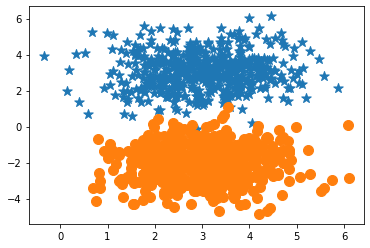

In [10]:
def plot_toy_data(x_data, y_truth, perceptron=None):
    blue = []
    orange = []
    black_blue = []
    black_orange = []
    if perceptron:
        y_pred = perceptron(x_data).squeeze().detach()
        y_pred = (y_pred > 0.5).float()
    else:
        y_pred = y_truth

    for x_i, y_true_i, y_pred_i in zip(x_data, y_truth, y_pred):
        
        is_black = y_true_i != y_pred_i

        if y_true_i == 1.:
            if is_black:
                black_blue.append(x_i)
            else:
                blue.append(x_i)
        else:
            if is_black:
                black_orange.append(x_i)
            else:
                orange.append(x_i)
    
    if blue:
        blue = np.stack(blue)
        plt.scatter(blue[:,0], blue[:,1], marker="*", c="tab:blue", s=100)
    
    if orange:
        orange = np.stack(orange)
        plt.scatter(orange[:,0], orange[:,1], marker="o", c="tab:orange", s=100)

    if perceptron:
        if black_blue:
            black_blue = np.stack(black_blue)
            plt.scatter(black_blue[:,0], black_blue[:,1], marker="*", c="black", s=100)
        if black_orange:
            black_orange = np.stack(black_orange)
            plt.scatter(black_orange[:,0], black_orange[:,1], marker="o", c="black", s=100)

        # hyperplane
        xx = np.linspace(x_data[:,0].min() - 0.5, x_data[:,0].max() + 0.5, 30)
        yy = np.linspace(x_data[:,1].min() - 0.5, x_data[:,1].max() + 0.5, 30)
        xv, yv = np.meshgrid(xx, yy)
        xy = np.vstack([xv.ravel(), yv.ravel()]).T
        z = perceptron(torch.tensor(xy, dtype=torch.float)).detach().numpy().reshape(yv.shape)
        
        plt.contour(xx, yy, z, colors='k', linestyles=["--", "-", "--"], levels=[0.4, 0.5, 0.6])
    plt.show()

plot_toy_data(*get_toy_data(1024))
# plot_toy_data(*get_toy_data(1024), perceptron)


In [11]:
class Perceptron(torch.nn.Module):

    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 1)

    def forward(self, x_in):
        return torch.sigmoid(self.fc1(x_in))

    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

x = torch.randn(5).view(5, 1).detach().clone()
print(x)
perceptron = Perceptron(input_dim=1)
y_prob = perceptron(x)
print(y_prob)
y_hat = (y_prob > 0.5).float()
print(y_hat)

tensor([[-2.0260],
        [-2.0655],
        [-1.2054],
        [-0.9122],
        [-1.2502]])
tensor([[0.9111],
        [0.9139],
        [0.8321],
        [0.7927],
        [0.8376]], grad_fn=<SigmoidBackward>)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])


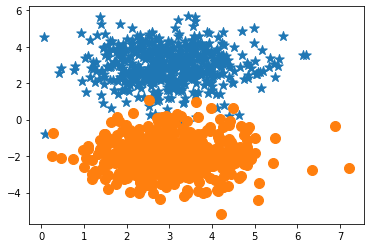

In [12]:
lr = 0.01
input_dim = 2

batch_size = 1000
n_epochs = 12
n_batches = 5

perceptron = Perceptron(input_dim=input_dim)
optimizer = torch.optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = torch.nn.BCELoss()

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
plot_toy_data(x_data_static, y_truth_static)

epoch: 0 loss: 1.36


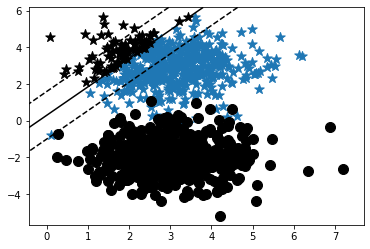

epoch: 1 loss: 1.3


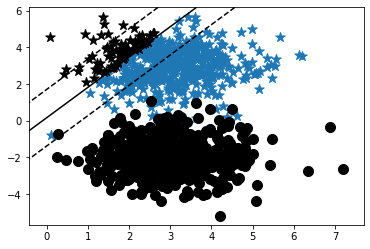

epoch: 2 loss: 1.16


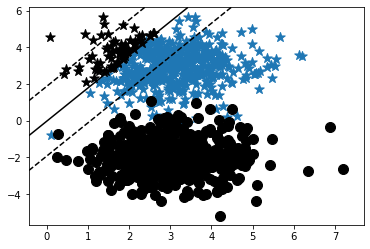

epoch: 3 loss: 1.02


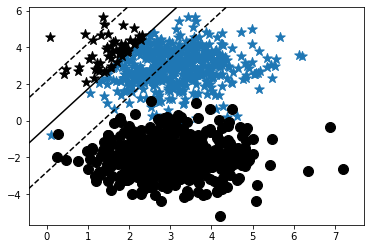

epoch: 4 loss: 0.924


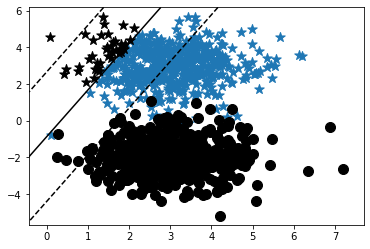

epoch: 5 loss: 0.847


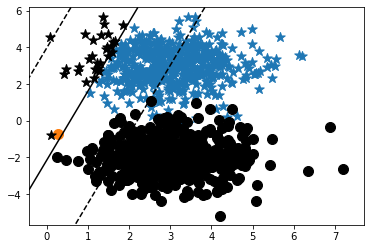

epoch: 6 loss: 0.761


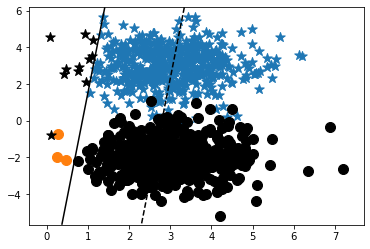

epoch: 7 loss: 0.684


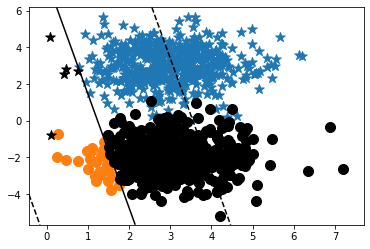

epoch: 8 loss: 0.627


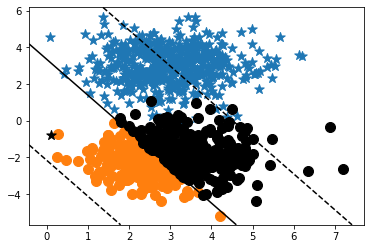

epoch: 9 loss: 0.575


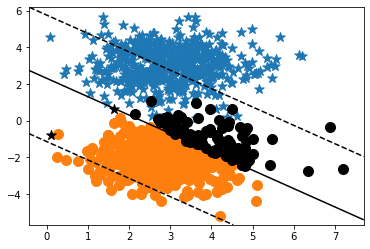

epoch: 10 loss: 0.526


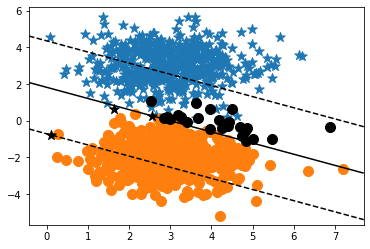

epoch: 11 loss: 0.482


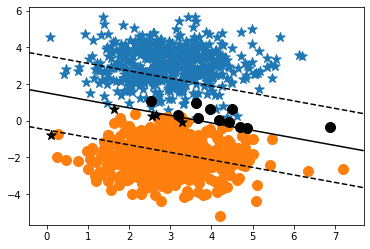

In [13]:
change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0

#while change > epsilon or epoch < n_epochs or last > 0.3:
for epoch in range(n_epochs):
    for _ in range(n_batches):

        optimizer.zero_grad()
        x_data, y_target = get_toy_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        
        loss = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value

    print(f"epoch: {epoch} loss: {loss:0.3}")
    plot_toy_data(x_data_static, y_truth_static, perceptron)
    
    
        


In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
class ToyDataset(Dataset):

    def __init__(self, x_data, y_truth):
        self.x = x_data
        self.y = y_truth

    def __getitem__(self, index):
        return (self.x[index], self.y[index])
        # return {"x": self.x[index], "y": self.y[index]}

    def __len__(self):
        return len(self.x)

toydataset = ToyDataset(x_data_static, y_truth_static)
print(toydataset[0])
print(toydataset[-3:])
len(toydataset)


(tensor([3.2976, 2.7892]), tensor(1.))
(tensor([[ 2.8339, -1.3578],
        [ 2.5962, -3.0151],
        [ 2.0137, -1.5765]]), tensor([0., 0., 0.]))


1000

In [16]:
toy_loader = DataLoader(dataset=toydataset, batch_size=12, shuffle=True, drop_last=True)

count = 0
for minibatch in toy_loader:
    print(minibatch)
    count += 1
    break
count

[tensor([[ 2.6312, -2.1946],
        [ 4.3856,  3.2805],
        [ 3.8707,  3.3736],
        [ 2.4292, -1.9057],
        [ 4.8371,  2.4691],
        [ 1.5645, -2.4507],
        [ 1.9891, -1.6273],
        [ 2.1133,  3.8917],
        [ 3.9285,  4.7300],
        [ 3.7208,  2.6658],
        [ 3.8594, -2.4259],
        [ 3.6549, -1.2763]]), tensor([0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.])]


1